I would like to share my approach for the lyft motion predction competition. I am new to Kaggle and machine learning so every comment/suggestion is welcome.

The model was trained for a small part of the data due to lack of hardware (between 1M-2M out of the ~20M samples, I don't have the exact number due to numerous subsequent runs in Kaggle notebooks/Colab).

**SETUP**

In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import PIL
import imageio
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Reshape, TimeDistributed,  Lambda,Dense, Concatenate, Flatten,Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D,  GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import  GlobalMaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras import layers
import random
from tensorflow.keras.utils import plot_model
import gc
from tensorflow.keras.preprocessing.image import array_to_img
 
DIR_INPUT = "../input/lyft-motion-prediction-autonomous-vehicles"
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
SINGLE_MODE_SUBMISSION = f"{DIR_INPUT}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DIR_INPUT}/multi_mode_sample_submission.csv"

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.evaluation import write_pred_csv
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
import random

print('loaded modules')

loaded modules


**CREATE AGENT DATASET**

In [2]:
cfg = {
    'format_version': 4,
    'model_params': {
        'history_num_frames': 9,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
        'raster_params': {
        'raster_size': [256,200],
        'pixel_size':[0.5,0.5], #[0.5,0.5],
        'ego_center': [0.2, 0.5], 
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,
        'disable_traffic_light_faces': False

    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 4
    },
    
     'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size':8,
        'shuffle': True,
        'num_workers': 4
    },
    
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 4
    },
    
    
    
}

dm = LocalDataManager()
dataset_path = dm.require(cfg["train_data_loader"]["key"])
chunked_dataset = ChunkedDataset(dataset_path)
# open the dataset
chunked_dataset.open(cached=False)
print(chunked_dataset)

val_dataset_path = dm.require(cfg["val_data_loader"]["key"])
val_chunked_dataset = ChunkedDataset(val_dataset_path)
val_chunked_dataset.open(cached=False)
print('validation dataset', val_chunked_dataset)

train_cfg = cfg["train_data_loader"]
val_cfg=cfg["val_data_loader"]

# Rasterizer
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)


train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open(cached=False)
train_dataset = AgentDataset(cfg, train_zarr, rasterizer,min_frame_future=10)

val_zarr = ChunkedDataset(dm.require(val_cfg["key"])).open(cached=False)
val_dataset = AgentDataset(cfg, val_zarr, rasterizer,min_frame_future=10)


print('Dataset created')


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
validation dataset +------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+--------

/kaggle/usr/lib/kaggle_l5kit/ipykernel_launcher.py:72: RuntimeWarning: you're running with custom min_frame_future of 10
/kaggle/usr/lib/kaggle_l5kit/ipykernel_launcher.py:75: RuntimeWarning: you're running with custom min_frame_future of 10


Dataset created


**VISUALIZING ONE RANDOM EXAMPLE**

history_availabilities 10.0
target_availabilities 50.0


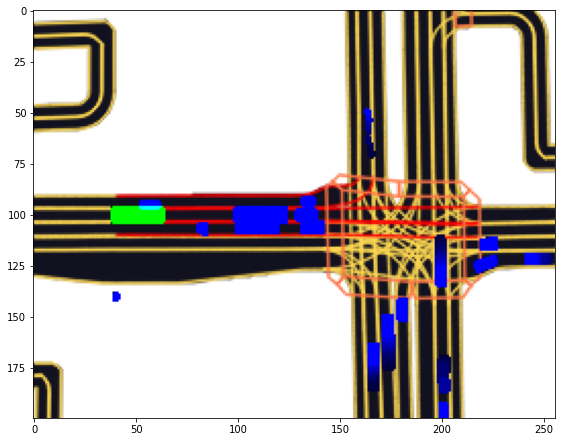

In [3]:
index=random.randint(0,len(train_dataset))
data=train_dataset[index]
print('history_availabilities',np.sum(data['history_availabilities']))
print('target_availabilities', np.sum(data['target_availabilities']) )
im = data["image"].transpose(1, 2, 0)
im = train_dataset.rasterizer.to_rgb(im)
impred=im
dpi = 80
height, width, depth = im.shape
figsize = 3*width / float(dpi), 3*height / float(dpi)
hist_positions_pixels = transform_points(transform_points(data["history_positions"],data["world_from_agent"]), data['world_to_image'])
target_positions_pixels = transform_points(transform_points(data["target_positions"],data["world_from_agent"]), data['world_to_image'])
fig = plt.figure(figsize=figsize)
center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
draw_trajectory(im, hist_positions_pixels,  [250,250, 38],radius=1)
draw_trajectory(im, target_positions_pixels, [8, 253, 8] ,radius=1)
plt.imshow(im)
plt.show()

**DATA INPUT PIPELINE**

In order to use 3D convolutions we have to carefully preprocess the data. The train_dataset returns an array of dimension (2*(history_num_frames+1)+3,height,width). The first history_num_frames+1 entries in the first axis correspond to agent frames, followed by history_num_frames+1 entries for the Ego frames, while the last 3 are the RGB channels of the semantic map. I will divide these 3 kind of inputs in the dataset generator.

To return the data in a tensorflow friendly format I create generator both for the training and validation dataset and use the from_generator method of tf.data.Dataset.

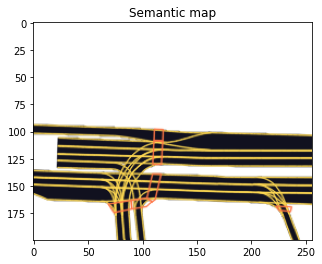

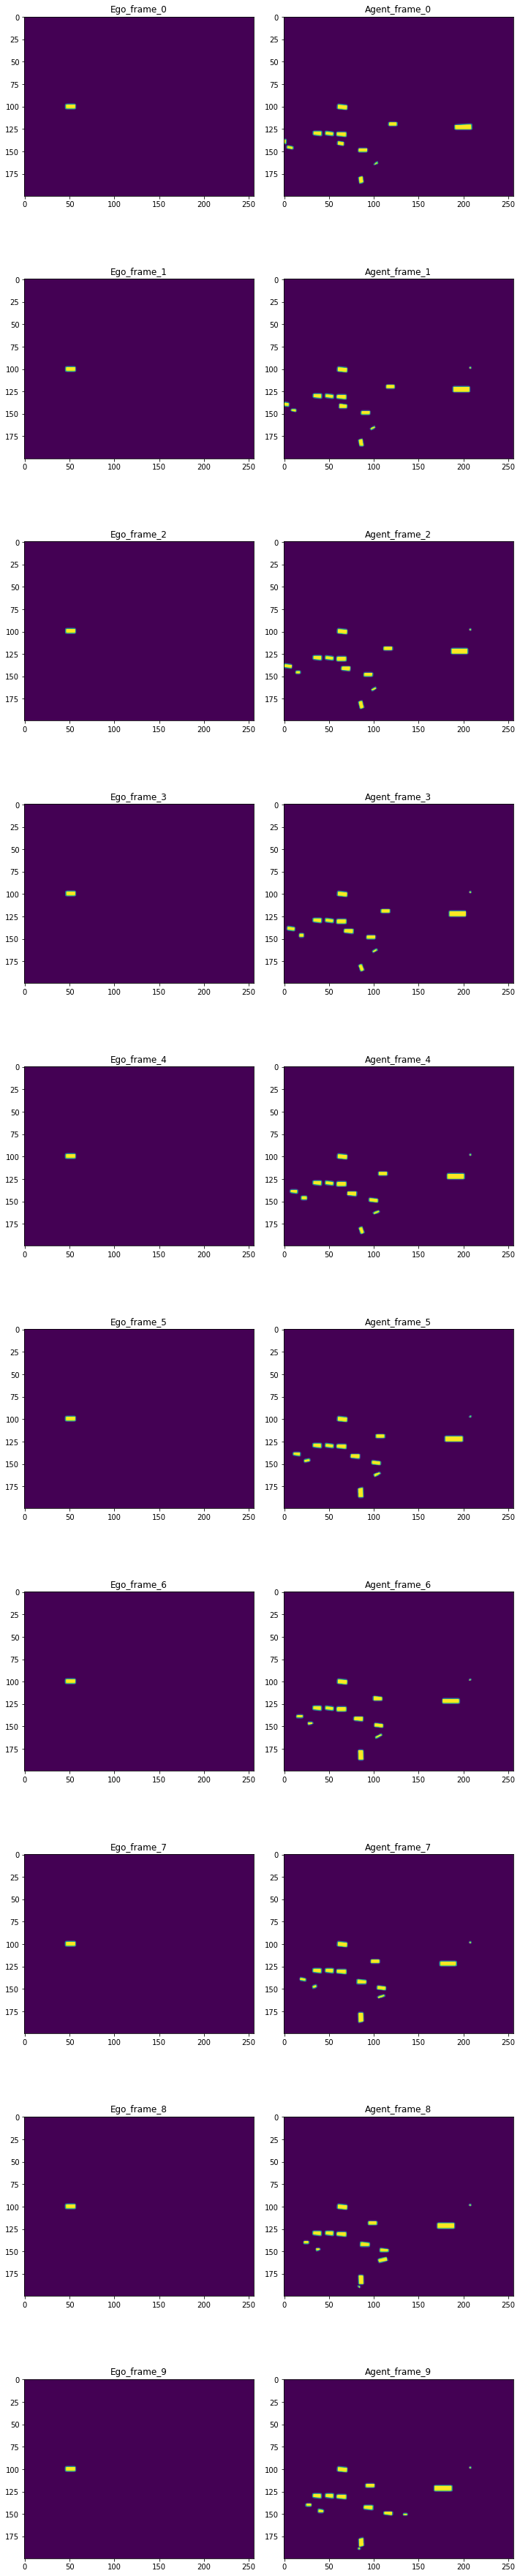

In [4]:
batch_size=32

num_time_frames=cfg["model_params"]["history_num_frames"]+1
#The generator 
def gen():
    while True:
        label=random.randint(0,len(train_dataset)-1)
        data=train_dataset[label]
        agent_frames=data['image'][0:num_time_frames,:,:]
        Ego_frames=data['image'][num_time_frames:((num_time_frames+1)*2-2),:,:]
        semantic_map=data['image'].transpose(1,2,0)[:,:,((num_time_frames+1)*2-2):]
        history_positions=data['history_positions']

        yield (Ego_frames, agent_frames, semantic_map,data['target_availabilities'],data['target_positions']),
        

#The generator 
def val_gen():
    while True:
        label=random.randint(0,len(val_dataset)-1)
        data=val_dataset[label]
        agent_frames=data['image'][0:num_time_frames,:,:]
        Ego_frames=data['image'][num_time_frames:((num_time_frames+1)*2-2),:,:]
        semantic_map=data['image'].transpose(1,2,0)[:,:,((num_time_frames+1)*2-2):]
        
        yield (Ego_frames, agent_frames, semantic_map,data['target_availabilities'],data['target_positions']),
        
train_ds = tf.data.Dataset.from_generator(gen,((tf.float32, tf.float32,tf.float32,tf.float32, tf.float32),))
val_ds = tf.data.Dataset.from_generator(val_gen,((tf.float32, tf.float32,tf.float32,tf.float32, tf.float32),))

  
def configure_for_performance(ds):
  ds = ds.batch(batch_size)
  ds = ds.prefetch(1)
  return ds

train_ds=configure_for_performance(train_ds)
val_ds=val_ds.batch(8)


#Let's visualize one example

for element in val_ds.take(1):
    ego=element[0][0]
    agent=element[0][1]
    sem_map=element[0][2]

fig=plt.figure()
plt.imshow(sem_map[0])
plt.title('Semantic map')

fig, axs=plt.subplots(nrows=10, ncols=2, figsize=(10,50))
for i in range(10):
    axs[i,0].imshow(ego[0,i,:,:])
    axs[i,0].set_title('Ego_frame_{}'.format(i))    
    axs[i,1].imshow(agent[0,i,:,:])
    axs[i,1].set_title('Agent_frame_{}'.format(i))
fig.tight_layout()



**MODEL ARCHITECTURE**

Let's go to the core of the model architecture. I will make use of 3D convolutions, the Convolutional Block Attention module from the paper

https://arxiv.org/abs/1807.06521

and a 3D version of it that I implemented.

Due to lack of hardware, to reduce the memory consuption of the model I first reduce the dimension of the semantic map, agent and Ego frames by a factor of 8 through the subsequent application of 2D strided convolutions mixed with CBAM blocks. The outputs of these are reshaped into tensors of shape (num_history_frames, img_heigth/8, img_width/8, num_channels) and then summed togheter.

We thus have, for each time frame, a 2D image with num_channels channels containing information about the semantic maps, the Ego, and the other agents.

We then feed this data to a series of (strided) 3D convolutions and 3D CBAM blocks. The output of the 3D convolutional part is fed, togheter with the output of 2D convolutions acting only on the semantic map, to a series of fully connected layers which give us the embedded representation of the input data.

The embedding vector is passed to the 3 prediction branches which are responsible of giving us the 3 predicted trajectories. Each prediction branch is conditioned on the output of the previous ones in the hope to make the predictions more diverse. So the first prediction branch receives as input the embedding vector, the second branch receives as input both the embedding vector and the output of the first prediction branch, while the third receives the embedding vector and the outputs of the other two branches. The predicted trajectory is given by a cumulative sum of the output of each prediction branch to reduce the magnitude of the weights the last layers need to learn. This helps stabilizing training.

Lastly, the output of each prediction branch togheter with the embedding vector is passed to two stacked fully connected layers that will return us the probability of each trajectory.

In [5]:
#Model architecture

ACT=tf.keras.layers.ELU(alpha=0.1)
num_halvings=3
embedding_dim=2048

def build_3DMLP(filter_size):
    inputs=Input(shape=filter_size)
    dense=Dense(filter_size, activation=ACT)(inputs)
    dense=Dense(filter_size//2, activation=ACT)(dense)
    dense=Dense(filter_size, activation='sigmoid')(dense)
    dense=Reshape((1,1,1,filter_size))(dense)
    MLP=Model(inputs=inputs, outputs=dense)
    return MLP

def build_MLP(filter_size):
    inputs=Input(shape=filter_size)
    dense=Dense(filter_size, activation=ACT)(inputs)
    dense=Dense(filter_size//2, activation=ACT)(dense)
    dense=Dense(filter_size, activation='sigmoid')(dense)
    dense=Reshape((1,1,filter_size))(dense)
    MLP=Model(inputs=inputs, outputs=dense)
    return MLP


def CBAM(inputs, filter_size):
    Avg=GlobalAveragePooling2D()(inputs)
    Max=GlobalMaxPooling2D()(inputs)
    MLP=build_MLP(filter_size)
    Max=MLP(Max)
    Avg=MLP(Avg)
    channel_attention=keras.activations.sigmoid(Avg+Max)
    channel_conditioned=tf.math.multiply(inputs, channel_attention)
    channel_average=Lambda(lambda x: keras.backend.mean(x, axis=-1,  keepdims=True))(channel_conditioned)
    channel_max=Lambda(lambda x: keras.backend.max(x, axis=-1,  keepdims=True))(channel_conditioned)
    spatial_reduction=Concatenate(axis=-1)([channel_average, channel_max])
    spatial_attention=Conv2D(filters=filter_size, kernel_size=11,padding='same', activation='sigmoid')(spatial_reduction)
    spatial_conditioned=tf.math.multiply(channel_conditioned, spatial_attention)
    
    return spatial_conditioned

def CBAM_3D(inputs, filter_size, kernel=(3,3,3)):
    Avg=GlobalAveragePooling3D()(inputs)
    Max=GlobalMaxPooling3D()(inputs)
    MLP=build_3DMLP(filter_size)
    Max=MLP(Max)
    Avg=MLP(Avg)
    channel_attention=keras.activations.sigmoid(Avg+Max)
    channel_conditioned=tf.math.multiply(inputs, channel_attention)
    channel_average=Lambda(lambda x: keras.backend.mean(x, axis=-1,  keepdims=True))(channel_conditioned)
    channel_max=Lambda(lambda x: keras.backend.max(x, axis=-1,  keepdims=True))(channel_conditioned)
    spatial_reduction=Concatenate(axis=-1)([channel_average, channel_max])
    spatial_attention=Conv3D(filters=filter_size, kernel_size=kernel,padding='same', activation='sigmoid')(spatial_reduction)
    spatial_conditioned=tf.math.multiply(channel_conditioned, spatial_attention)
    
    return spatial_conditioned


def pred_branch1(embedding, name=None):
    decoded=Dense(100)(embedding)
    decoded=Reshape([50,2])(decoded)
    trajectory=Lambda(lambda x:tf.math.cumsum(x,axis=1))(decoded)

    return trajectory, decoded

def pred_branch2(embedding,in1, name=None):
    in1=Flatten()(in1)
    in1=Dense(256, activation=ACT)(in1)
    in1=Dropout(0.2)(in1)
    embedding=Concatenate(axis=-1)([in1,embedding])
    embedding=Dense(embedding_dim, activation=ACT)(embedding)
    embedding=Dropout(0.5)(embedding)
    decoded=Dense(100)(embedding)
    decoded=Reshape([50,2])(decoded)
    trajectory=Lambda(lambda x:tf.math.cumsum(x,axis=1))(decoded)

    return trajectory, decoded

def pred_branch3(embedding,in1, in2, name=None):
    in1=Flatten()(in1)
    in1=Dense(256, activation=ACT)(in1)
    in1=Dropout(0.2)(in1)
    in2=Flatten()(in2)
    in2=Dense(256, activation=ACT)(in2)
    in2=Dropout(0.2)(in2)
    embedding=Concatenate(axis=-1)([in1,in2, embedding])
    embedding=Dense(embedding_dim, activation=ACT)(embedding)
    embedding=Dropout(0.5)(embedding)
    decoded=Dense(100)(embedding)
    decoded=Reshape([50,2])(decoded)
    trajectory=Lambda(lambda x:tf.math.cumsum(x,axis=1))(decoded)

    return trajectory,decoded





availaibilities_shape=50
map_spatial_shape=cfg['raster_params']['raster_size']
history_frames=cfg['model_params']['history_num_frames']
time_frames=history_frames+1

#Number of halvings from original image shape
def build_model():
# INPUTS    
    
    Ego_input=Input(shape=[time_frames,map_spatial_shape[0],map_spatial_shape[1]], name='Ego_input')
    agent_input=Input(shape=[time_frames,map_spatial_shape[0],map_spatial_shape[1]], name='agent_input')
    map_input=Input(shape=[map_spatial_shape[0],map_spatial_shape[1],3], name='map_input')
    
   
#MAP COMBINATION AND DIMENSION REDUCTION 
    analize_map=map_input

    analize_map=Conv2D(filters=32, kernel_size=7, padding='same', activation=ACT)(analize_map)
    
    attention=CBAM(analize_map,32)
    analize_map=Conv2D(filters=32, kernel_size=3, activation=ACT, padding='same')(analize_map+attention)

    for i in range(num_halvings):
        analize_map=Conv2D(filters=32*(2**(i)), kernel_size=3, activation=ACT, strides=2, padding='same')(analize_map)
        attention=CBAM(analize_map,32*(2**(i)))
        analize_map=Conv2D(filters=32*(2**(i)), kernel_size=3, activation=ACT, padding='same')(analize_map+attention)

    map_embedding=Conv2D(filters=64, kernel_size=3, activation=ACT)(analize_map)
    attention=CBAM(map_embedding,64)
    map_embedding=MaxPooling2D(pool_size=4)(map_embedding+attention)
    map_embedding=Flatten()(map_embedding)
    map_embegging=Dense(1024, activation=ACT)(map_embedding)
    map_embedding=Dropout(0.5)(map_embedding)

    analize_map=Conv2D(filters=64, kernel_size=1, activation=ACT)(analize_map)


   
    analize_map=Reshape([1,map_spatial_shape[0]//(2**num_halvings),map_spatial_shape[1]//(2**num_halvings),64], name='map_reshape')(analize_map)
    
    analize_Ego=Reshape([time_frames,map_spatial_shape[0],map_spatial_shape[1],1], name='Ego_reshape')(Ego_input)
    
    for i in range(num_halvings):
        analize_Ego=TimeDistributed(Conv2D(filters=16, kernel_size=3, padding='same', strides=(2,2), activation=ACT))(analize_Ego)
    
    analize_Ego=TimeDistributed(Conv2D(filters=64, kernel_size=1, activation=ACT, name='analized_Ego'))(analize_Ego)
                                                             
    analize_agent=Reshape([time_frames,map_spatial_shape[0],map_spatial_shape[1],1], name='agent_reshape')(agent_input)
    
    for i in range(num_halvings):
        analize_agent=TimeDistributed(Conv2D(filters=16, kernel_size=3, padding='same', strides=(2,2), activation=ACT))(analize_agent)
    
    analize_agent=TimeDistributed(Conv2D(filters=64, kernel_size=1, activation=ACT, name='analized_agent'))(analize_agent)

    frame=Lambda(lambda x: tf.math.add(x[0],x[1]))([analize_Ego, analize_agent])
    frame=Lambda(lambda x: tf.math.add(x[0],x[1]))([frame, analize_map])
    #eventually try to add here a time distributed conv2D layer
     
#MAP ENCODER    
    kernel=3
    kernel_shape = (kernel,kernel,kernel)
    
    skip=frame    
    skip=frame    
    attention=CBAM_3D(frame,64, kernel=(5,7,7))
    frame=Conv3D(filters=64, kernel_size=kernel_shape, padding='same', activation=ACT)(frame+attention) 
    frame=Conv3D(filters=128, kernel_size=kernel_shape, padding='same', strides=(2,2,2), activation=ACT)(frame+skip) 
    skip=frame
    attention=CBAM_3D(frame,128,kernel=(3,7,7))
    frame=Conv3D(filters=128, kernel_size=kernel_shape, padding='same', activation=ACT)(frame+attention) 
    frame=Conv3D(filters=256, kernel_size=kernel_shape, padding='same', strides=(2,2,2), activation=ACT)(frame+skip) 
    skip=frame
    attention=CBAM_3D(frame,256,kernel=(3,7,7))
    frame=Conv3D(filters=256, kernel_size=kernel_shape, padding='same', activation=ACT)(frame+attention) 
    frame=Conv3D(filters=512, kernel_size=kernel_shape, padding='same', strides=(2,2,2), activation=ACT)(frame+skip) 
    attention=CBAM_3D(frame,512,kernel=(2,4,4))
    frame=Conv3D(filters=1024, kernel_size=(2,3,3), padding='same', strides=(2,2,2), activation=ACT)(frame+attention) 

    
#EMBEDDING       
    embedding=Flatten()(frame)
    embedding=Dense(2048, activation=ACT)(embedding)
    embedding=Dropout(0.5)(embedding)    
    embedding=Concatenate(axis=-1)([embedding, map_embedding])
    embedding=Dense(4096, activation=ACT)(embedding)
    embedding=Dropout(0.5)(embedding)
    embedding=Dense(embedding_dim, activation=ACT)(embedding)
    embedding=Dropout(0.5)(embedding)
    pred1,decoded1=pred_branch1(embedding, name='pred1')
    pred2,decoded2=pred_branch2(embedding,decoded1, name='pred2')
    pred3,decoded3=pred_branch3(embedding,decoded1,decoded2, name='pred3')
    
    analize_pred1=Flatten()(decoded1)
    analize_pred1=Dense(256, activation=ACT)(analize_pred1)
    analize_pred1=Dropout(0.2)(analize_pred1)
    analize_pred2=Flatten()(decoded2)
    analize_pred2=Dense(256, activation=ACT)(analize_pred2)
    analize_pred2=Dropout(0.2)(analize_pred2)
    analize_pred3=Flatten()(decoded3)
    analize_pred3=Dense(256, activation=ACT)(analize_pred3)
    analize_pred3=Dropout(0.2)(analize_pred3)
    confidence_infos=Concatenate(axis=-1)([analize_pred1, analize_pred2, analize_pred3, embedding])
    confidence_infos=Dense(4096, activation=ACT)(confidence_infos)
    confidence_infos=Dropout(0.5)(confidence_infos)
    confidences=Dense(3, activation='softmax', name='confidences')(confidence_infos)
    
    model=Model(inputs=[Ego_input,agent_input,map_input], outputs=[pred1, pred2, pred3, confidences])
    
    return model

lyft_model=build_model()
lyft_model.summary()


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
map_input (InputLayer)          [(None, 256, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 200, 32) 4736        map_input[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           conv2d[0][0]                     
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 32)           0           conv2d[0][0]                     
______________________________________________________________________________________

In [6]:
plot_model(lyft_model, to_file='model.png',show_shapes=True, show_layer_names=True)

**LOSS AND TRAINING PIPELINE**

In order to use the multi loglikelihood to score our predictions we need to build a loss function that combines the different outputs. I implemented this in Keras by wrapping the model into another model and use the add.loss method that allows to compute the loss using the outputs of intermediate layers.

loaded weights
(None, 50)
Epoch 1/10
500/500 [==============================] - 1433s 3s/step - loss: 23.5443 - val_loss: 19.2877
Epoch 2/10
500/500 [==============================] - 1374s 3s/step - loss: 24.0314 - val_loss: 31.1921
Epoch 3/10
500/500 [==============================] - 1362s 3s/step - loss: 23.7042 - val_loss: 11.7888
Epoch 4/10
500/500 [==============================] - 1360s 3s/step - loss: 23.3458 - val_loss: 19.2989
Epoch 5/10
500/500 [==============================] - 1368s 3s/step - loss: 23.0094 - val_loss: 13.8720
Epoch 6/10
500/500 [==============================] - 1365s 3s/step - loss: 24.0377 - val_loss: 28.0799
Epoch 7/10
500/500 [==============================] - 1367s 3s/step - loss: 23.0624 - val_loss: 19.5886
Epoch 8/10
500/500 [==============================] - 1368s 3s/step - loss: 22.9642 - val_loss: 19.1173
Epoch 9/10
500/500 [==============================] - 1370s 3s/step - loss: 21.7827 - val_loss: 15.1839
Epoch 10/10
500/500 [=================

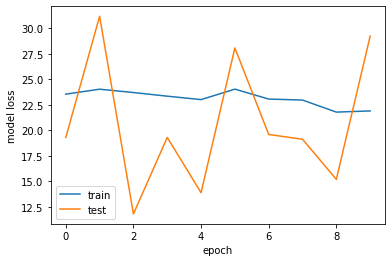

In [7]:
continue_training=True
if continue_training:
    lyft_model.load_weights('../input/lyft-weights/nobnweights.h5')
    print('loaded weights')
 
 
def multi_log_likelihood(gt, pred1,pred2,pred3,confidences):
      confidence1,confidence2,confidence3=tf.unstack(confidences,3, axis=-1)
      pred1x,pred1y=tf.unstack(pred1,2,axis=-1)
      pred2x,pred2y=tf.unstack(pred2,2,axis=-1)
      pred3x,pred3y=tf.unstack(pred3,2,axis=-1)
      gtx,gty=tf.unstack(gt,2,axis=-1)
      print(gtx.shape)
      err1=-(1/2)*(tf.math.reduce_sum(tf.math.square(gtx-pred1x),axis=-1)+tf.math.reduce_sum(tf.math.square(gty-pred1y),axis=-1,name='err1'))
      err2=-(1/2)*(tf.math.reduce_sum(tf.math.square(gtx-pred2x),axis=-1)+tf.math.reduce_sum(tf.math.square(gty-pred2y),axis=-1))
      err3=-(1/2)*(tf.math.reduce_sum(tf.math.square(gtx-pred3x),axis=-1)+tf.math.reduce_sum(tf.math.square(gty-pred3y),axis=-1))
      max12=tf.math.maximum(err1,err2)
      mx=tf.math.maximum(err3,max12)
      exp1=tf.math.exp(err1-mx)
      exp2=tf.math.exp(err2-mx)
      exp3=tf.math.exp(err3-mx)
      return -mx-tf.math.log(confidence1*exp1+confidence2*exp2+confidence3*exp3)
    
    
def build_wrapper_model(model):
    Ego_input=Input(shape=[time_frames,map_spatial_shape[0],map_spatial_shape[1]], name='Ego_input')
    agent_input=Input(shape=[time_frames,map_spatial_shape[0],map_spatial_shape[1]], name='agent_input')
    map_input=Input(shape=[map_spatial_shape[0],map_spatial_shape[1],3], name='map_input')
    availabilities_mask_input=Input(shape=availaibilities_shape, name='availabilities_mask_input')
    targets=Input(shape=(availaibilities_shape,2), name='targets')
 
    pred1,pred2,pred3,confidences=model([Ego_input,agent_input,map_input])
    mask_availabilities=Reshape((availaibilities_shape,1))(availabilities_mask_input)
    pred1=Lambda(lambda x: tf.math.multiply(x[0], x[1]), name='pred1')([pred1, mask_availabilities])
    pred2=Lambda(lambda x: tf.math.multiply(x[0], x[1]), name='pred2')([pred2, mask_availabilities])
    pred3=Lambda(lambda x: tf.math.multiply(x[0], x[1]), name='pred3')([pred3, mask_availabilities])
    wrapper_model=Model(inputs=[Ego_input,agent_input,map_input, availabilities_mask_input, targets], outputs=[pred1, pred2, pred3, confidences])
    wrapper_model.add_loss(multi_log_likelihood(targets,pred1,pred2,pred3,confidences))
 
    return wrapper_model

wrapper=build_wrapper_model(lyft_model)

call=[tf.keras.callbacks.ModelCheckpoint(
    'checkweights.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    options=None),
      
       tf.keras.callbacks.CSVLogger('log.csv')] 
Optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-6)

wrapper.compile(optimizer=Optimizer, experimental_steps_per_execution=10)
 
 
history = wrapper.fit(train_ds,validation_data=val_ds, epochs=10, steps_per_epoch=500, callbacks=call, validation_steps=25, verbose=1)
#ATTENTION: choose if to save weights
save_weights=True
#save weights
if save_weights:
    lyft_model.save_weights('Lyft_weights.h5')
    print('weights saved')

   
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('history.png')
plt.show()